<a href="https://colab.research.google.com/github/vanleiko/bootcamp-alura/blob/main/Projeto_final_bootcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objetivo** 

Criar um modelo de Machine Learning capaz de ajudar os médicos e enfermeiros do Hospital Sírio-Libanês a prever quais pacientes precisarão ser admitidos na unidade de terapia intensiva (UTI) devido a complicações da COVID-19 e, assim, definir qual a necessidade de leitos de UTI do Hospital a partir dos dados clínicos individuais disponíveis. 

Portanto, nosso modelo deve ser capaz de classificar se um paciente irá (1) ou não irá (0) para UTI, que é a nossa variável-alvo.



 

**Modelo de Machine Learning**

Seguindo a [definição da IBM](https://www.ibm.com/cloud/learn/machine-learning), **Machine Learning** é um ramo da Inteligência Artificial que foca na construção de algoritmos que são treinados para serem capazes de aprender com os dados e a encontrar padrões, com o objetivo de fazerem previsões e tomarem decisões a partir de novos dados.


*Workflow adaptado de [Workflow of a Machine Learning project](https://towardsdatascience.com/workflow-of-a-machine-learning-project-ec1dba419b94)*

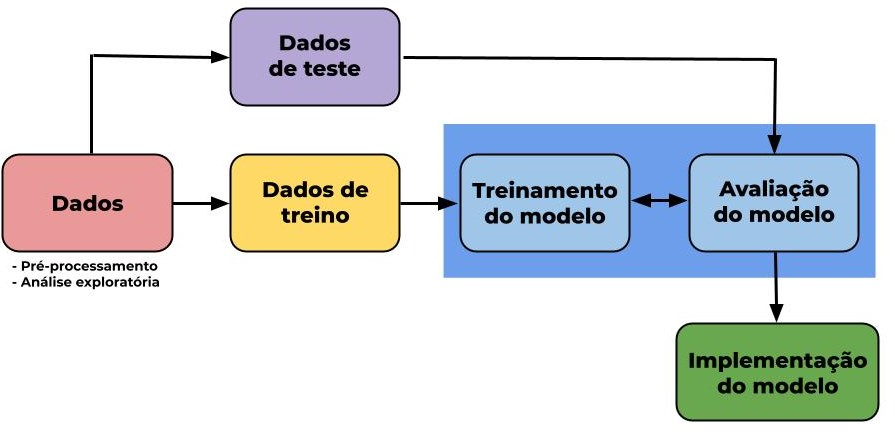

**Impacto do modelo**

Sabendo-se quantos e quando os pacientes precisarão de um leito de UTI, é possível fazer uma melhor gestão desses leitos a fim de que o Hospital não atinja sua capacidade de ocupação máxima, evitando uma ruptura do sistema. 

Antecipando essa situação, é possível:

a) preparar, com antecedência, a transferência de pacientes para UTIs de outros hospitais que tenham mais leitos disponíveis;

b) planejar o recebimento de pacientes de outros hospitais. 

**Fonte dos dados**

Os dados foram fornacidos pelo Hospital Sírio-Libanês, sendo que esses dados estão anonimizados e seus valores já normalizados.

**Resultados**

(PREENCHER)
___

<font color="red">**Informações e dicas passadas pelo próprio Hospital e que serão seguidas para construção do modelo:**

***1. Não utilizar os dados em que a variável "UTI" seja igual a 1***

Não devemos usar os dados em que a variável-alvo UTI esteja presente, pois não sabemos se aqueles dados foram coletados antes ou depois do paciente ter sido encaminhado para UTI.



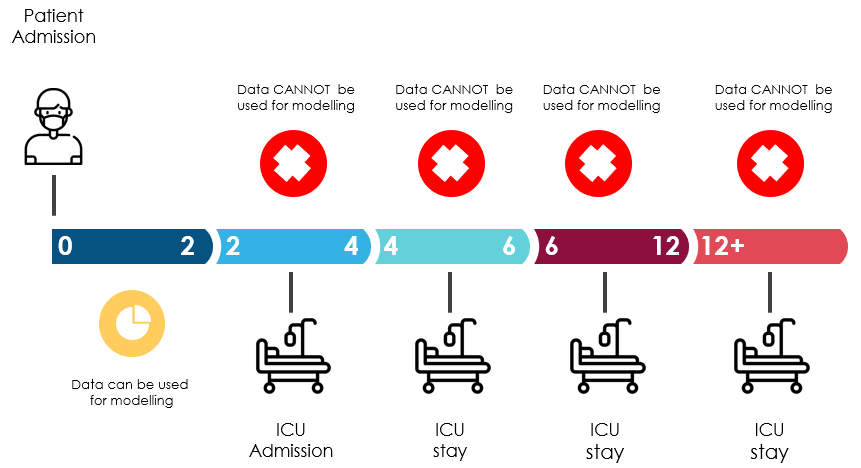

***2. É razoável admitir que pacientes que tenha alguns registros em branco estejam em situação clínica estável, apresentando sinais clínicos e vitais semelhantes ao da janela vizinha***

Pode-se preencher os valores faltantes com os valores da janela anterior ou posterior.

***3. Quanto mais cedo a previsão, melhor***

Embora o uso dos dados de todas as janelas possa gerar um modelo com maior acurácia, um bom modelo usando apenas a primeira janela (0h-2h) é clinicamente mais relevante.

##<font color="darkblue">**Variáveis do Dataset**

**Esse dataset é composto por 54 variáveis, sendo elas:**

- Informações demográficas: 3 variáveis do tipo categórica

- Doenças pré-existentes: 9 variáveis do tipo categórica

- Exames de sangue: 36 variáveis do tipo contínua ---> quando necessário, expandidas em média, mediana, max, min, diff(max-min) e diff relativa (diff/mediana)

- Sinais vitais: 6 variáveis do tipo contínua

**Dados de saída:**

- ICU: nossa variável-alvo, que indica se o paciente foi ou não para UTI

**Janela de eventos:**

- WINDOW: janela em que os eventos ocorreram a partir da admissão no Hospital

  - 0 - 2	
  - 2 - 4	
  - 4 - 6	
  - 6 - 12
  - Above 12



##<font color="purple">**0 Pré-processamento e análise exploratória dos dados**



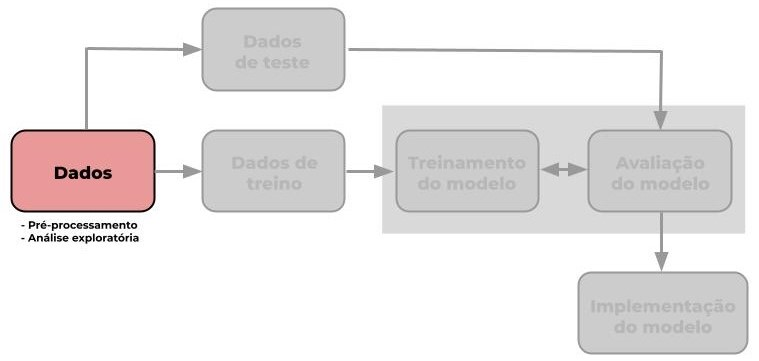

###**Pré-processamento**

Seguindo as orientações passadas pelo próprio Hospital, os dados serão pré-processados da seguinte forma:

1 - Remover aqueles pacientes que chegaram e foram para a UTI na janela 0-2h

2 - Preencher as células vazias das variáveis contínuas (exames de sangue e sinais vitais)

3 - Deixar apenas os dados referentes à janela 0-2h de cada paciente (1 paciente/linha)

4 - Transformar o AGE_PERCENTIL, para que cada categoria seja uma coluna e seus valores passem a ser binários 

5 - Remover os NAN das variáveis categóricas

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# ler e salvar o arquivo com os dados
dados = pd.read_excel("https://github.com/vanleiko/bootcamp-alura/blob/main/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true")
dados.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [ ]:
# verificar quantos pacientes têm no dataset
quantidade_pacientes = len(dados["PATIENT_VISIT_IDENTIFIER"].unique())
print(f"Total de {quantidade_pacientes} pacientes deram entrada no Hospital")

Total de 385 pacientes deram entrada no Hospital


**1 - Remover aqueles pacientes que chegaram e foram para a UTI na janela 0-2h**

Esses dados devem ser removidos, pois não contribuem para nosso modelo, visto que não sabemos se os dados coletados nessa janela refletem valores de exames feitos antes ou depois do paciente ter dado entrada na UTI. 

Dados coletados após o paciente ter dado entrada na UTI não devem ser usados para o modelo.

In [ ]:
def remove_pacientes_UTI_primeira_janela(dados):
  
  id_pacientes_para_remover = dados.query("ICU == 1 and WINDOW == '0-2'")["PATIENT_VISIT_IDENTIFIER"]  
  total_pacientes_para_remover = len(id_pacientes_para_remover)

  df_final = dados.query("PATIENT_VISIT_IDENTIFIER not in @id_pacientes_para_remover")
   
  return total_pacientes_para_remover, df_final

**2 - Preencher as células vazias das variáveis contínuas**

As células em branco a serem preenchidas referem-se apenas às variávies de **exames de sangue** e **sinais vitais**, que estão entre as colunas 13 até a antipenúltima coluna. 

Células em branco podem ser entendidas que o paciente encontra-se em estado clínico estável, portanto, podem ser usados os valores das células vizinhas para seu preenchimento.

In [ ]:
 def preenche_celulas_vazias(dados):

  variaveis_continuas = dados.iloc[:, 13:-2].columns

  df_continuas = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[variaveis_continuas].fillna(method="bfill").fillna(method="ffill")
  df_categoricas = dados.iloc[:, :13]
  df_categoricas_saida = dados.iloc[:, -2:]

  df_final = pd.concat([df_categoricas, df_continuas, df_categoricas_saida], axis=1, ignore_index=True)
  df_final.columns = dados.columns
  
  return df_final

**3 - Deixar apenas os dados referentes à janela 0-2h de cada paciente**

Usar aqueles dados que foram coletados durante a janela de adminissão 0-2h *(quanto mais cedo a previsão, melhor)*

  a) caso o paciente tenha ido para UTI em qualquer uma das janelas posteriores, atribuir "UTI" = 1; 

  b) caso o paciente não tenha ido para UTI nas janelas posteriores, "UTI" continua como 0. 

In [ ]:
# seleciona apenas os dados da janela 0-2h 
# coloca 1 na "UTI" se o paciente foi para a UTI em qualquer outra janela posterior a 0-2h

def primeira_janela(rows):
  if (np.any(rows["ICU"])):
    rows.loc[rows["WINDOW"] == "0-2", "ICU"] = 1
    
  return rows.loc[rows["WINDOW"] == "0-2"]

In [ ]:
# agrupa cada paciente em 1 linha e aplica a função anterior

def uma_linha_por_paciente(dados):
  df_final = dados.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False).apply(primeira_janela)
  df_final = df_final.reset_index(drop=True)

  return df_final

**4 - Transformar o AGE_PERCENTIL, para que cada categoria seja uma coluna e seus valores passem a ser binários** 

Como a coluna "AGE_PERCENTIL" está com valores categóricos (10th, 20th, 30th, 40th, etc), colocar cada um desses valores como coluna, e atribuir 0 ou 1 para o percentil em que o paciente se encontra. 

In [ ]:
def converte_categorica_para_binaria(dados):

  df_age_percentil = pd.get_dummies(dados[["AGE_PERCENTIL"]]) 
  df_final = pd.concat([df_age_percentil, dados], axis=1)
  df_final = df_final.drop("AGE_PERCENTIL", axis=1)

  return df_final

**FUNÇÂO PRINCIPAL**

Essa função irá chamar todas as funções anteriores para fazer o pré-processamento dos dados:

In [ ]:
def processamento_dados(dados):

  pacientes_removidos, df1 = remove_pacientes_UTI_primeira_janela(dados)
  print(f"(1) {pacientes_removidos} pacientes removidos")

  df2 = preenche_celulas_vazias(df1)
  print("(2) Células em branco das variáveis contínuas foram preenchidas")

  df3 = uma_linha_por_paciente(df2)
  print("(3) Uma linha por paciente referente aos dados da janela 0-2")

  df_final = converte_categorica_para_binaria(df3)
  print("(4) AGE_PERCENTIL convertido para binário")
  print("Todas as funções foram executadas")

  return df_final

In [ ]:
# Chamando a função principal
dados_processados = processamento_dados(dados)

(1) 32 pacientes removidos
(2) Células em branco das variáveis contínuas foram preenchidas
(3) Uma linha por paciente referente aos dados da janela 0-2
(4) AGE_PERCENTIL convertido para binário
Todas as funções foram executadas


In [ ]:
dados_processados.head()

,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,1,0,0,0,0,0,0,0,0,0,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,0,0,0,1,0,0,0,0,0,0,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,1,0,0,0,0,0,0,0,0,0,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
4,1,0,0,0,0,0,0,0,0,0,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,...,-1.000000,-1.0,-0.037037,-0.538462,-0.53773

In [ ]:
# ficamos com 353 pacientes
dados_processados.shape

(353, 240)

**5 - Remover os NAN que não serão preenchidos nas variáveis categóricas**

Como as células vazias das variáveis categóricas (informações demográficas e doenças pré-existentes) não podem ser preenchidas com valores de células vizinhas (visto que se referem a valores de pacientes distintos), essas células serão removidas. 

In [ ]:
# há 9 células com NaN
(dados_processados.isna().sum()).value_counts()

0    231
1      9
dtype: int64

In [ ]:
# verificar onde estão essas células com NaN
celulas_vazias = dados_processados.isna().any(axis=1)

In [ ]:
# há 1 paciente que tem 9 células com NaN
dados_processados[celulas_vazias]

,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
183,1,0,0,0,0,0,0,0,0,0,199,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,...,-0.978029,-1.0,0.100944,-0.355656,-0.012209,-0.577268,0.07563,0.653251,0.08642,-0.384615,0.056604,-0.517241,0.107143,0.684211,-0.175258,-0.25,-0.213675,-0.571429,0.252747,0.818182,-0.076923,-0.351351,-0.134328,-0.515152,0.130435,0.736842,-0.478261,-0.631902,-0.648855,-0.823529,-0.595238,-0.919192,-0.608696,-0.607383,-0.790037,-0.817204,-0.599662,-0.918403,0-2,0


In [ ]:
# remover esse paciente que está no índice 183
dados_limpos = dados_processados.drop(183)

In [ ]:
# agora há 352 pacientes no nosso dataframe
dados_limpos.shape

(352, 240)

**O que foi feito até agora:**

- Começamos o pré-processamento dos dados com 385 pacientes

- Removemos 32 pacientes que deram entrada na UTI na janela 0-2h

- Preenchemos as células vazias dos valores referentes aos exames de sangue e sinais vitais

- Escolhemos analisar os dados coletados na janela 0-2h. Se o paciente foi para a UTI nas janelas posteriores, atribuímos 1 à variável "UTI", se não foi para UTI nas janelas posteriores, continua com zero

- Removemos 1 paciente que tinha NaN nas variáveis referentes às doenças pré-existentes

- Termiamos esse pré-processamento com 352 pacientes



In [ ]:
dados_limpos

,AGE_PERCENTIL_10th,AGE_PERCENTIL_20th,AGE_PERCENTIL_30th,AGE_PERCENTIL_40th,AGE_PERCENTIL_50th,AGE_PERCENTIL_60th,AGE_PERCENTIL_70th,AGE_PERCENTIL_80th,AGE_PERCENTIL_90th,AGE_PERCENTIL_Above 90th,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,0,0,0,0,1,0,0,0,0,0,1,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
1,1,0,0,0,0,0,0,0,0,0,2,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
2,0,0,0,1,0,0,0,0,0,0,3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
3,1,0,0,0,0,0,0,0,0,0,4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0.076923,-0.351351,-0.044776,-0.575758,0.072464,0.894737,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-1.000000,-0.883669,-0.956805,-0.870968,-0.953536,-0.980333,0-2,0
4,1,0,0,0,0,0,0,0,0,0,5,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1

###**Análise exploratória**

In [ ]:
# separa as variáveis (colunas) do dataframe
def separa_variaveis(dados, inicio, fim):
  df = dados.iloc[:, inicio:fim]
  dados_uti = dados["ICU"]

  df["ICU"] = dados_uti

  if "PATIENT_VISIT_IDENTIFIER" in df.columns:
    df = df.drop("PATIENT_VISIT_IDENTIFIER", axis=1)

  return df

In [ ]:
# faz o melt do dataframe
def cria_melt(dados):
  df = pd.melt(dados, id_vars="ICU", var_name="variavel", value_name="valor")
  return df


In [ ]:
# plota gráfico
def cria_grafico(dados, titulo):
  
  sns.catplot(data=dados.query("valor == 1"), x="variavel", hue="ICU", kind="count", aspect=3, height=5, legend=False, zorder=3)
  plt.grid(axis="y",  linestyle="dashed", zorder=0)
  plt.title(titulo, fontsize=16, fontweight="bold")

  plt.xticks(rotation=40, horizontalalignment="right", fontweight="bold")
  plt.yticks(np.arange(0, 170, step=10))

  plt.xlabel("Variável", fontsize=18)  
  plt.ylabel("Quantidade de pacientes", fontsize=18)

  plt.legend(loc="upper left",  title="UTI", labels=["Não", "Sim"], title_fontsize=16, fontsize="x-large")  

**Informações demográficas**

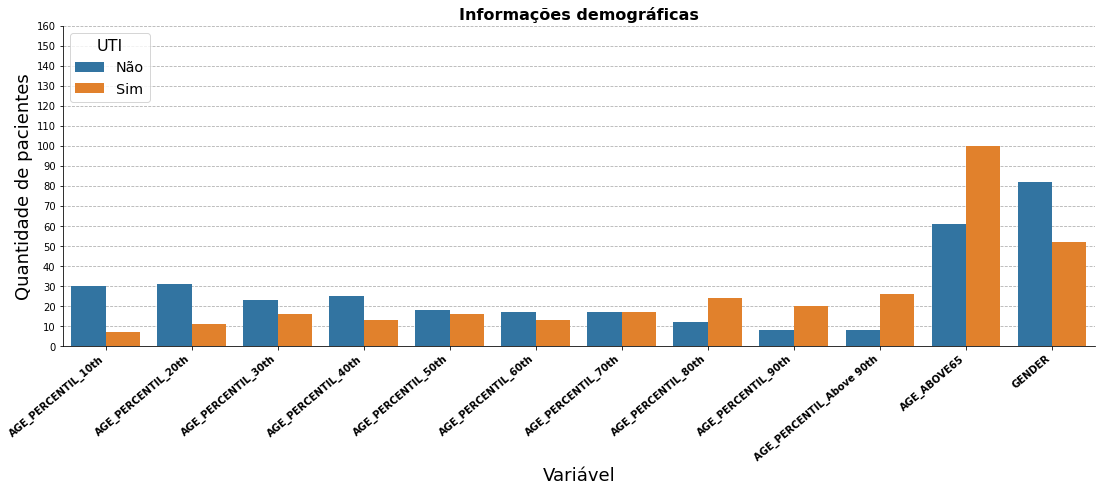

In [ ]:
dados_info_demograficas = separa_variaveis(dados_limpos, 0, 13)
grafico_info_demograficas = cria_melt(dados_info_demograficas)
cria_grafico(grafico_info_demograficas, "Informações demográficas")


**Doenças pré-existentes**

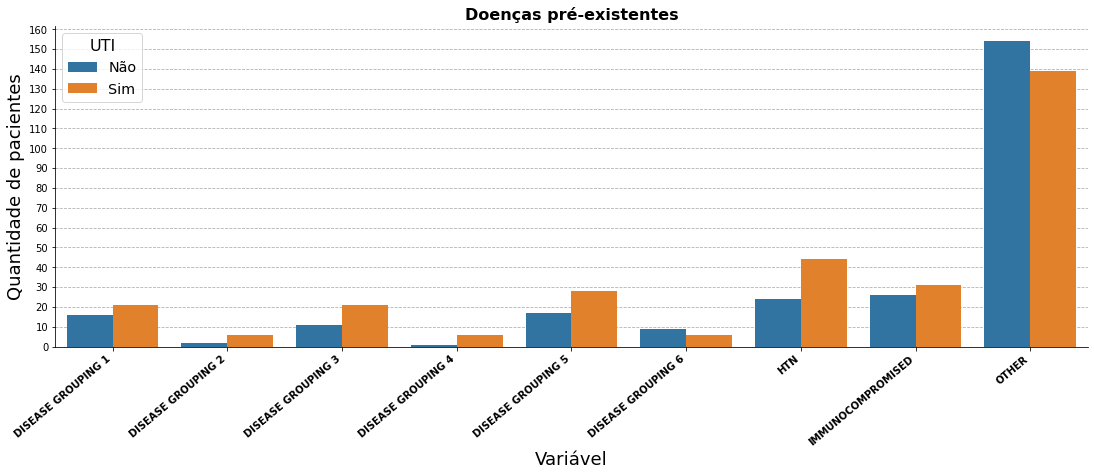

In [ ]:
dados_doencas_preexistente = separa_variaveis(dados_limpos, 13, 22)
grafico_doencas_preexistente  = cria_melt(dados_doencas_preexistente)
cria_grafico(grafico_doencas_preexistente, "Doenças pré-existentes")

**Exames de sangue e sinais vitais**

In [ ]:
dados_exames = separa_variaveis(dados_limpos, 22, 238)
grafico_exames = cria_melt(dados_exames)

In [ ]:
grafico_exames.variavel.unique()

array(['ALBUMIN_MEDIAN', 'ALBUMIN_MEAN', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'ALBUMIN_DIFF', 'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN',
       'BE_ARTERIAL_MIN', 'BE_ARTERIAL_MAX', 'BE_ARTERIAL_DIFF',
       'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN', 'BE_VENOUS_MIN',
       'BE_VENOUS_MAX', 'BE_VENOUS_DIFF', 'BIC_ARTERIAL_MEDIAN',
       'BIC_ARTERIAL_MEAN', 'BIC_ARTERIAL_MIN', 'BIC_ARTERIAL_MAX',
       'BIC_ARTERIAL_DIFF', 'BIC_VENOUS_MEDIAN', 'BIC_VENOUS_MEAN',
       'BIC_VENOUS_MIN', 'BIC_VENOUS_MAX', 'BIC_VENOUS_DIFF',
       'BILLIRUBIN_MEDIAN', 'BILLIRUBIN_MEAN', 'BILLIRUBIN_MIN',
       'BILLIRUBIN_MAX', 'BILLIRUBIN_DIFF', 'BLAST_MEDIAN', 'BLAST_MEAN',
       'BLAST_MIN', 'BLAST_MAX', 'BLAST_DIFF', 'CALCIUM_MEDIAN',
       'CALCIUM_MEAN', 'CALCIUM_MIN', 'CALCIUM_MAX', 'CALCIUM_DIFF',
       'CREATININ_MEDIAN', 'CREATININ_MEAN', 'CREATININ_MIN',
       'CREATININ_MAX', 'CREATININ_DIFF', 'FFA_MEDIAN', 'FFA_MEAN',
       'FFA_MIN', 'FFA_MAX', 'FFA_DIFF', 'GGT_MEDIAN', 'GGT_MEAN',
    

Text(0.5, 1.0, 'Exames de sangue e sinais vitais')

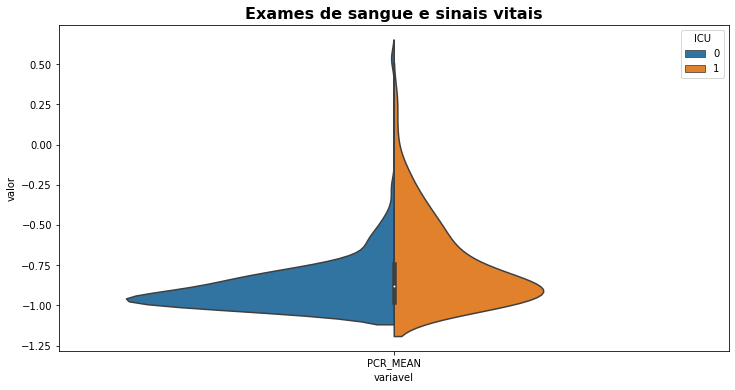

In [ ]:
plt.figure(figsize=(12,6))
sns.violinplot(x="variavel", y="valor", data=grafico_exames.query("variavel =='PCR_MEAN'"), hue="ICU", split=True)
plt.title("Exames de sangue e sinais vitais", fontsize=16, fontweight="bold")